# 10Q Sentiment & DCF Analysis
This notebook analyzes the DCF of a 10Q as well as the sentiment of the writings within the report for a given ticker and predicts its future price movement.

### Imports & Config

In [223]:
import os, re, sys, time, math, json, warnings, requests
from datetime import datetime, timedelta, timezone, date
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
from dotenv import load_dotenv
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TextClassificationPipeline
from functools import lru_cache
import requests, time
from urllib3.util.retry import Retry
from requests.adapters import HTTPAdapter
from pathlib import Path
import matplotlib.pyplot as plt

import logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s | %(levelname)s | %(message)s",
    datefmt="%H:%M:%S"
)
log = logging.getLogger("10Q-DCF")

warnings.filterwarnings("ignore")
load_dotenv()

SEC_EMAIL = os.getenv("SEC_EMAIL")
POLYGON_API_KEY = os.getenv("POLYGON_API_KEY")

TRADIER_ACCESS_TOKEN = os.getenv("TRADIER_ACCESS_TOKEN")
TRADIER_ACCOUNT_ID = os.getenv("TRADIER_ACCOUNT_ID")
TRADIER_BASE = os.getenv("TRADIER_BASE")

def _tradier_headers():
    # Ensure TRADIER_ACCESS_TOKEN and TRADIER_BASE are set in .env
    return {
        "Authorization": f"Bearer {TRADIER_ACCESS_TOKEN}",
        "Accept": "application/json"
    }

FINBERT_ID = "yiyanghkust/finbert-tone"
SECTION_PATTERNS = [
    (r"item\s+2\.\s*management[’']?s discussion and analysis.*?(?=item\s+3\.)", "MD&A"),
    (r"item\s+1a\.\s*risk factors.*?(?=item\s+2\.)", "RiskFactors"),
    (r"results of operations.*?(?=liquidity|capital resources|item\s+\d)", "Results"),
]
POS_PHRASES = [r"strong demand", r"margin expansion", r"raised guidance", r"record (revenue|earnings)", r"cost (reductions|optimization)", r"share repurchase", r"cash flow (improved|growth)"]
NEG_PHRASES = [r"decline in (sales|revenue)", r"margin compression", r"impairment charge", r"supply chain disruption", r"adversely affected", r"weaker demand", r"material weakness"]

SEC_HEADERS = {
    "User-Agent": "severin.spagnola@sjsu.edu",
    "Accept": "application/json",
}

_SEC_TICKER_CACHE = None  # lazy-loaded

def cap_bucket(mc):
    if mc is None or not np.isfinite(mc): return "unknown"
    mc_b = mc / 1e9
    if mc_b < 0.3:  return "micro"
    if mc_b < 2:    return "small"
    if mc_b < 10:   return "mid"
    if mc_b < 200:  return "large"
    return "mega"

BACKTEST_CSV = "10q_sentiment_event_returns.csv"
BASELINES_JSON = "sentiment_baselines.json"

### SEC + HTML Helpers

In [224]:
def _zero_pad_cik(x: str) -> str:
    """Return 10-digit zero-padded CIK from a numeric string."""
    return f"{int(x):010d}"

def _load_ticker_table() -> dict:
    """
    Load the official SEC ticker->CIK table once:
    https://www.sec.gov/files/company_tickers.json
    Returns dict: { 'AAPL': '0000320193', ... }
    """
    global _SEC_TICKER_CACHE
    if _SEC_TICKER_CACHE is not None:
        return _SEC_TICKER_CACHE

    url = "https://www.sec.gov/files/company_tickers.json"
    r = requests.get(url, headers=SEC_HEADERS, timeout=30)
    r.raise_for_status()
    raw = r.json()  # { "0": {"ticker":"A","cik_str":47217,"title":"Agilent Technologies, Inc."}, ... }

    table = {}
    for _, row in raw.items():
        table[str(row["ticker"]).upper()] = _zero_pad_cik(str(row["cik_str"]))
    _SEC_TICKER_CACHE = table
    return table

def normalize_cik(identifier: str) -> str:
    """
    Accepts a ticker like 'WHR', a bare CIK '106640', or strings like 'CIK0000106640'
    Returns a 10-digit, zero-padded CIK string, e.g. '0000106640'
    """
    s = str(identifier).strip().upper()

    # If they passed 'CIK....', strip the prefix
    if s.startswith("CIK"):
        s = s[3:].strip()

    # Pure digits -> pad
    if re.fullmatch(r"\d+", s):
        return _zero_pad_cik(s)

    # Otherwise treat as ticker
    tickers = _load_ticker_table()
    if s in tickers:
        return tickers[s]

    raise ValueError(f"Could not resolve identifier to CIK: {identifier}")


def sec_get_submissions(ticker_or_cik: str) -> dict:
    cik10 = normalize_cik(ticker_or_cik)
    url = f"https://data.sec.gov/submissions/CIK{cik10}.json"
    r = requests.get(url, headers=SEC_HEADERS, timeout=30)
    if r.status_code == 429:
        time.sleep(1.2)  # gentle backoff if rate-limited
        r = requests.get(url, headers=SEC_HEADERS, timeout=30)
    r.raise_for_status()
    return r.json()

def list_10q_with_dates(ticker_or_cik: str, max_n: int | None = None):
    """
    Return recent 10-Q metadata as a list of dicts:
    [{ 'filing_date', 'accession', 'primary', 'url', 'cik' }, ...] (newest first)
    """
    sub = sec_submissions_json(ticker_or_cik)
    forms = sub["filings"]["recent"]["form"]
    accs  = sub["filings"]["recent"]["accessionNumber"]
    dates = sub["filings"]["recent"]["filingDate"]
    prims = sub["filings"]["recent"].get("primaryDocument", [""]*len(forms))

    cik_int = int(sub["cik"])
    rows = []
    for f, a, d, p in zip(forms, accs, dates, prims):
        if f == "10-Q":
            acc_nodash = a.replace("-", "")
            primary = p or "index.html"
            url = f"https://www.sec.gov/Archives/edgar/data/{cik_int}/{acc_nodash}/{primary}"
            rows.append({
                "filing_date": d,
                "accession": a,
                "primary": primary,
                "url": url,
                "cik": cik_int,
            })
    # newest first
    rows = sorted(rows, key=lambda r: r["filing_date"], reverse=True)
    return rows[:max_n] if max_n else rows

def fetch_filing_html(*args) -> str:
    """
    Accepts either:
      (cik, accession, primary)  -> builds the URL
      (url,)                     -> uses the given URL directly
    """
    if len(args) == 1:
        url = args[0]
    elif len(args) == 3:
        cik, accession, primary = args
        acc_nodash = str(accession).replace("-", "")
        url = f"https://www.sec.gov/Archives/edgar/data/{int(cik)}/{acc_nodash}/{primary}"
    else:
        raise TypeError("fetch_filing_html expects (url) or (cik, accession, primary)")
    r = requests.get(url, headers=SEC_HEADERS, timeout=60)
    r.raise_for_status()
    return r.text

def _make_soup(html: str) -> BeautifulSoup:
    for parser in ("lxml", "html5lib", "html.parser"):
        try:
            return BeautifulSoup(html, parser)
        except Exception:
            pass
    return BeautifulSoup(html, "html.parser")

def _lower_clean(txt: str) -> str:
    return re.sub(r"[ \t]+"," ", txt.lower())

def extract_sections(html: str, patterns=SECTION_PATTERNS, fallback_full=True, cap=60000) -> dict:
    soup = _make_soup(html)
    txt  = soup.get_text("\n", strip=True)
    low  = _lower_clean(txt)
    out = {}
    for pat, name in patterns:
        m = re.search(pat, low, flags=re.S)
        if m: out[name] = low[m.start():m.end()][:cap]
    if not out and fallback_full: out["FullDocument"] = low[:cap]
    return out

def _session():
    s = requests.Session()
    retries = Retry(total=3, backoff_factor=0.5,
                    status_forcelist=(429,500,502,503,504),
                    allowed_methods=frozenset(["GET"]))
    s.mount("https://", HTTPAdapter(max_retries=retries))
    return s

@lru_cache(maxsize=None)
def _ticker_to_cik_map():
    url = "https://www.sec.gov/files/company_tickers.json"
    r = _session().get(url, headers=SEC_HEADERS, timeout=30)
    r.raise_for_status()
    data = r.json()
    out = {}
    for _, row in data.items():
        out[row["ticker"].upper()] = int(row["cik_str"])
    return out

def get_cik(ticker_or_cik):
    # accepts "AAPL" or 320193; returns int CIK
    if isinstance(ticker_or_cik, str) and not ticker_or_cik.isdigit():
        t = ticker_or_cik.upper()
        if t not in _ticker_to_cik_map():
            raise ValueError(f"Unknown ticker for SEC map: {t}")
        return _ticker_to_cik_map()[t]
    return int(ticker_or_cik)

def _cik10(cik_int: int) -> str:
    return f"{int(cik_int):010d}"

def sec_submissions_url(ticker_or_cik) -> str:
    # ALWAYS builds the correct zero-padded URL
    cik = get_cik(ticker_or_cik)
    return f"https://data.sec.gov/submissions/CIK{_cik10(cik)}.json"

def sec_submissions_json(ticker_or_cik):
    url = sec_submissions_url(ticker_or_cik)
    r = _session().get(url, headers=SEC_HEADERS, timeout=30)
    r.raise_for_status()
    time.sleep(0.2)  # be polite
    return r.json()


### FinBERT Loader + Long-Text Analysis

In [225]:
def load_finbert():
    tok = AutoTokenizer.from_pretrained(FINBERT_ID)
    mdl = AutoModelForSequenceClassification.from_pretrained(FINBERT_ID)
    pipe = TextClassificationPipeline(model=mdl, tokenizer=tok, top_k=None, truncation=True)
    return pipe, tok

def _token_chunks(text: str, tokenizer, max_tokens=512, stride=32):
    ids = tokenizer.encode(text, add_special_tokens=False)
    step = max_tokens - stride
    for i in range(0, len(ids), step):
        window = ids[i:i+max_tokens]
        if not window: break
        yield tokenizer.decode(window, skip_special_tokens=True)

def finbert_sent_long(text: str, pipe, tokenizer, max_tokens=512, batch=16):
    if len(text) < 4000:
        rows = pipe([text], truncation=True, max_length=max_tokens)
    else:
        chunks = list(_token_chunks(text, tokenizer, max_tokens=max_tokens))
        rows = []
        for i in range(0, len(chunks), batch):
            rows.extend(pipe(chunks[i:i+batch], truncation=True, max_length=max_tokens))
    pos = neu = neg = 0.0
    for r in rows:
        d = {x["label"].lower(): x["score"] for x in r}
        pos += d.get("positive",0.0); neu += d.get("neutral",0.0); neg += d.get("negative",0.0)
    n = max(1, len(rows))
    return {"pos":pos/n, "neu":neu/n, "neg":neg/n, "sent_score":pos/n - neg/n}

def phrase_boost(text: str, pos_list=POS_PHRASES, neg_list=NEG_PHRASES, w=0.1) -> float:
    boost = 0.0
    for p in pos_list:
        if re.search(p, text, flags=re.I): boost += w
    for n in neg_list:
        if re.search(n, text, flags=re.I): boost -= w
    return boost

def score_sections(sections: dict, pipe_tok=None) -> dict:
    pipe, tok = pipe_tok if pipe_tok else load_finbert()
    feats = {}
    for name, text in sections.items():
        fb = finbert_sent_long(text, pipe, tok, max_tokens=512, batch=16)
        boost = phrase_boost(text)
        feats[f"{name}_pos"] = fb["pos"]; feats[f"{name}_neg"] = fb["neg"]
        base = fb.get("sent_score", 0.0)
        feats[f"{name}_sent"] = base + boost
        feats[f"{name}_boost"] = boost
    sents = [v for k,v in feats.items() if k.endswith("_sent")]
    feats["sent_overall"] = float(np.mean(sents)) if sents else np.nan
    return feats


### Price Data from Polygon

In [226]:
def polygon_daily(ticker: str, start: str, end: str) -> pd.DataFrame:
    url = f"https://api.polygon.io/v2/aggs/ticker/{ticker.upper()}/range/1/day/{start}/{end}"
    params = {"adjusted":"true","sort":"asc","limit":50000,"apiKey": POLYGON_API_KEY}
    r = requests.get(url, params=params, timeout=30); r.raise_for_status()
    rows = r.json().get("results", []) or []
    if not rows: return pd.DataFrame(columns=["date","close"])
    df = pd.DataFrame(rows)[["t","c"]]
    df["date"] = pd.to_datetime(df["t"], unit="ms", utc=True).dt.tz_convert("US/Eastern").dt.date
    return df.drop(columns=["t"]).rename(columns={"c":"close"}).drop_duplicates("date")

def polygon_latest_close(ticker: str, lookback_days: int = 14):
    """Get the most recent daily close from Polygon within the last N days."""
    end = date.today()
    start = end - timedelta(days=lookback_days)
    df = polygon_daily(ticker, start.isoformat(), end.isoformat())
    if df.empty: return None
    return float(df.iloc[-1]["close"])

def next_trading_close(df: pd.DataFrame, target_date: date):
    s = df[df["date"] >= target_date]
    return None if s.empty else float(s.iloc[0]["close"])

def event_closes(ticker: str, filing_date: str) -> dict:
    d0 = datetime.strptime(filing_date, "%Y-%m-%d").date()
    d7 = d0 + timedelta(days=7)
    d28= d0 + timedelta(days=28)
    start = (d0 - timedelta(days=5)).strftime("%Y-%m-%d")
    end   = (d28 + timedelta(days=5)).strftime("%Y-%m-%d")
    df = polygon_daily(ticker, start, end)
    if df.empty: return {"close_0":np.nan,"close_7":np.nan,"close_28":np.nan}
    return {"close_0": next_trading_close(df,d0),
            "close_7": next_trading_close(df,d7),
            "close_28":next_trading_close(df,d28)}

# === D2) Annualized volatility from Polygon daily closes ===
def annualized_vol_from_polygon(ticker: str, lookback_days: int = 252, winsor_pct: float = 0.0):
    """
    Compute annualized volatility from daily close-to-close returns.
    - Pulls ~1.6x lookback to survive holidays/missing days, then trims.
    - Optional winsorization of returns to reduce single-day outlier impact.
    Returns: float (annualized vol) or None if insufficient data.
    """
    # fetch a bit more than needed to handle gaps
    start = (date.today() - timedelta(days=int(lookback_days * 1.6))).isoformat()
    end   = date.today().isoformat()
    df = polygon_daily(ticker, start, end)
    if df is None or df.empty or "close" not in df.columns:
        return None

    # ensure chronological order and trim to last N trading rows
    df = df.sort_values("date").tail(lookback_days + 5)  # keep a small cushion
    px = df["close"].astype(float)
    rets = px.pct_change().dropna()
    if rets.empty:
        return None

    # optional winsorization of returns
    if winsor_pct and 0 < winsor_pct < 0.5:
        lo, hi = rets.quantile(winsor_pct), rets.quantile(1 - winsor_pct)
        rets = rets.clip(lo, hi)

    daily_std = float(rets.std(ddof=0))
    ann_vol = daily_std * (252 ** 0.5)
    return ann_vol

### Daily OHLC + Helpers

In [227]:
def polygon_daily_ohlc(ticker: str, start: str, end: str) -> pd.DataFrame:
    """
    Return daily OHLC between [start, end] (YYYY-MM-DD), US/Eastern dates.
    Columns: date, open, high, low, close
    """
    url = f"https://api.polygon.io/v2/aggs/ticker/{ticker.upper()}/range/1/day/{start}/{end}"
    params = {"adjusted": "true", "sort": "asc", "limit": 50000, "apiKey": POLYGON_API_KEY}
    r = requests.get(url, params=params, timeout=30); r.raise_for_status()
    rows = r.json().get("results", []) or []
    if not rows:
        return pd.DataFrame(columns=["date","open","high","low","close"])
    df = pd.DataFrame(rows)[["t","o","h","l","c"]].rename(
         columns={"t":"ts","o":"open","h":"high","l":"low","c":"close"})
    df["date"] = pd.to_datetime(df["ts"], unit="ms", utc=True).dt.tz_convert("US/Eastern").dt.date
    return df.drop(columns=["ts"]).drop_duplicates("date")

def next_trading_open(df_ohlc: pd.DataFrame, target_date: date) -> float | None:
    s = df_ohlc[df_ohlc["date"] >= target_date]
    return None if s.empty else float(s.iloc[0]["open"])

### CSV Backtest Builder

In [228]:
def backtest_10q_sentiment(tickers, max_filings=6, sleep_sec=0.3):
    pipe_tok = load_finbert()
    rows = []
    for t in tickers:
        print(f"[{t}] pulling 10-Qs…")
        cik = get_cik(t)
        pairs = list_10q_with_dates(cik, max_n=max_filings)  # list of dicts
        for p in pairs:
            try:
                # you can call with URL directly
                html = fetch_filing_html(p["url"])
            except Exception as e:
                print(f"  skip {p['accession']} ({e})"); continue
            secs  = extract_sections(html)
            feats = score_sections(secs, pipe_tok=pipe_tok)
            px    = event_closes(t, p["filing_date"])
            row   = {"ticker":t,"cik":cik, **p, **feats, **px}
            c0,c7,c28 = row["close_0"], row["close_7"], row["close_28"]
            row["ret_7"]  = (c7/c0 - 1.0)*100 if c0 and c7 else np.nan
            row["ret_28"] = (c28/c0 - 1.0)*100 if c0 and c28 else np.nan
            rows.append(row)
            time.sleep(sleep_sec)
    df = pd.DataFrame(rows)
    df.to_csv(BACKTEST_CSV, index=False)
    print(f"Saved {BACKTEST_CSV} with {len(df)} rows.")
    return df


### Backtest Analyzer

In [229]:
from scipy.stats import pearsonr

def run_legitimacy_checks(path=BACKTEST_CSV):
    df = pd.read_csv(path)
    df["filing_date"] = pd.to_datetime(df["filing_date"])
    df = df.dropna(subset=["ret_7","ret_28"])
    sent_cols = [c for c in df.columns if c.endswith("_sent")]
    def winsorize(s, p=0.01):
        lo, hi = s.quantile(p), s.quantile(1-p)
        return s.clip(lo, hi)
    df["ret_7_w"]  = winsorize(df["ret_7"])
    df["ret_28_w"] = winsorize(df["ret_28"])

    def corr_table(y_col):
        rows=[]
        for c in sent_cols + (["sent_overall"] if "sent_overall" in df.columns else []):
            x,y = df[c], df[y_col]
            m = x.notna() & y.notna()
            if m.sum() < 8: rows.append((c, np.nan, np.nan)); continue
            r,p = pearsonr(x[m], y[m])
            rows.append((c,r,p))
        return pd.DataFrame(rows, columns=["feature","pearson_r","p_value"]).sort_values("pearson_r", ascending=False)

    corr7, corr28 = corr_table("ret_7_w"), corr_table("ret_28_w")
    df = df.sort_values(["ticker","filing_date"])
    df["Δsent_overall"] = df.groupby("ticker")["sent_overall"].diff()

    def corr_delta(y_col):
        rows=[]
        x,y = df["Δsent_overall"], df[y_col]
        m = x.notna() & y.notna()
        if m.sum() >= 8:
            r,p = pearsonr(x[m], y[m]); rows.append(("Δsent_overall", r, p))
        return pd.DataFrame(rows, columns=["feature","pearson_r","p_value"]).sort_values("pearson_r", ascending=False)

    dc7, dc28 = corr_delta("ret_7_w"), corr_delta("ret_28_w")
    return {"corr7":corr7, "corr28":corr28, "dc7":dc7, "dc28":dc28}

### Market Cap Baselines

In [230]:
def polygon_market_cap(ticker: str):
    url = f"https://api.polygon.io/v3/reference/tickers/{ticker.upper()}"
    params = {"apiKey": POLYGON_API_KEY}
    r = requests.get(url, params=params, timeout=20)
    try:
        js = r.json().get("results", {})
        return js.get("market_cap", None)
    except Exception:
        return None

def fit_bucket_baselines(path=BACKTEST_CSV, min_per_bucket=8,
                         ret_clip_pct=0.01,             # winsorize tails of returns (1% each side)
                         dsent_abs_cap=0.12             # hard cap on |Δsent_overall| to limit leverage
                        ):
    """
    Train per-cap baselines using robust-ish preprocessing:
      - compute Δsent_overall per ticker
      - attach current market cap + bucket
      - winsorize returns within each bucket (ret_7, ret_28)
      - cap |Δsent_overall| at dsent_abs_cap
    Saves sentiment_baselines.json
    """
    def _winsorize(series: pd.Series, p=0.01):
        lo, hi = series.quantile(p), series.quantile(1-p)
        return series.clip(lo, hi)

    df = pd.read_csv(path)
    df = df.dropna(subset=["ret_7","ret_28","sent_overall"]).copy()
    df["filing_date"] = pd.to_datetime(df["filing_date"])
    df = df.sort_values(["ticker","filing_date"])
    df["Δsent_overall"] = df.groupby("ticker")["sent_overall"].diff()

    # attach current market cap + bucket
    mcap = {}
    for t in df["ticker"].unique():
        try:
            mcap[t] = polygon_market_cap(t)
            time.sleep(0.2)
        except Exception:
            mcap[t] = None
    df["market_cap"] = df["ticker"].map(mcap)
    df["bucket"] = df["market_cap"].map(cap_bucket)

    out = {}
    for bucket in sorted(df["bucket"].dropna().unique()):
        d = df[df["bucket"] == bucket].dropna(subset=["Δsent_overall","ret_7","ret_28"]).copy()
        if len(d) < min_per_bucket:
            continue

        # --- winsorize per-bucket ---
        d["ret_7_w"]  = _winsorize(d["ret_7"],  p=ret_clip_pct)
        d["ret_28_w"] = _winsorize(d["ret_28"], p=ret_clip_pct)

        # cap Δsent_overall to reduce leverage from rare huge text swings
        d["Δsent_overall_c"] = d["Δsent_overall"].clip(-dsent_abs_cap, dsent_abs_cap)

        # fit simple OLS: ret ~ a + b * Δsent_overall_c
        for horizon, ycol in (("ret7","ret_7_w"), ("ret28","ret_28_w")):
            X = np.c_[np.ones(len(d)), d["Δsent_overall_c"].values]
            y = d[ycol].values
            beta = np.linalg.pinv(X).dot(y)  # [intercept, slope]
            intercept, slope = float(beta[0]), float(beta[1])
            out.setdefault(bucket, {})[horizon] = {
                "intercept": intercept,
                "slope": slope,
                "n": int(len(d)),
                "ret_clip_pct": ret_clip_pct,
                "dsent_abs_cap": dsent_abs_cap
            }

    with open(BASELINES_JSON,"w") as f:
        json.dump(out, f, indent=2)
    print(f"Saved {BASELINES_JSON} (winsorized)")
    return out

### Filing → prediction using bucket baselines (no re-scoring required)

In [231]:
def _clip(x, lo, hi): return max(lo, min(hi, x))

def predict_from_row(row: dict, baselines: dict, bucket: str = None) -> dict:
    """
    Use fitted cap-bucket regression to predict 7d/28d returns from Δsent_overall.
    Expects row to contain: ticker, filing_date, sent_overall for this filing AND the previous one.
    If you call this with the raw CSV rows, we compute Δsent per ticker on the fly in the orchestrator.
    """
    bkt = bucket or "large"
    base = baselines.get(bkt, {})
    ds_cap = base.get("ret28", {}).get("dsent_abs_cap", 0.12) or 0.12
    # default slope/intercept = 0 if bucket missing
    a7  = base.get("ret7",  {}).get("intercept", 0.0);  b7  = base.get("ret7",  {}).get("slope", 0.0)
    a28 = base.get("ret28", {}).get("intercept", 0.0);  b28 = base.get("ret28", {}).get("slope", 0.0)
    ds  = _clip(float(row["Δsent_overall"]), -ds_cap, ds_cap)
    pred7  = float(a7  + b7  * ds)
    pred28 = float(a28 + b28 * ds)
    # Return only the predictions; direction will be decided upstream
    return {"pred_ret_7d_pct": pred7, "pred_ret_28d_pct": pred28}

### Trailing-stop simulation on daily bars

In [232]:
def simulate_trade_28d(df_ohlc: pd.DataFrame,
                       start_date: date,
                       direction: int,
                       tsl_pct: float = 0.05,
                       max_days: int = 28) -> dict:
    """
    direction: +1 long, -1 short.
    Entry: next trading OPEN on/after start_date.
    Exit: earliest of (TSL hit using day-lows/highs) or after max_days at CLOSE.
    Returns dictionary with P&L% and basic path info.
    """
    df = df_ohlc[df_ohlc["date"] >= start_date].reset_index(drop=True)
    if df.empty:
        return {"filled": False, "pnl_pct": np.nan}

    entry_open = float(df.loc[0, "open"])
    entry_day  = df.loc[0, "date"]

    # Long: trailing from running max; Short: trailing from running min
    run_max = entry_open
    run_min = entry_open
    stop    = None

    def _update_trail_long(px_max):
        return px_max * (1 - tsl_pct)
    def _update_trail_short(px_min):
        return px_min * (1 + tsl_pct)  # short stops out if price rises above trail

    exit_reason = "time"
    exit_price  = float(df.iloc[min(max_days-1, len(df)-1)]["close"])
    exit_day    = df.iloc[min(max_days-1, len(df)-1)]["date"]

    for i in range(len(df)):
        o,h,l,c, d = float(df.loc[i,"open"]), float(df.loc[i,"high"]), float(df.loc[i,"low"]), float(df.loc[i,"close"]), df.loc[i,"date"]
        if direction == 1:
            run_max = max(run_max, h)
            stop = _update_trail_long(run_max)
            # stop check intraday against low
            if l <= stop:
                # approximate fill at stop (conservative)
                exit_reason, exit_price, exit_day = "tsl", stop, d
                break
        else:
            run_min = min(run_min, l)
            stop = _update_trail_short(run_min)
            if h >= stop:
                exit_reason, exit_price, exit_day = "tsl", stop, d
                break

    # PnL
    if direction == 1:
        pnl = (exit_price / entry_open - 1.0) * 100.0
    else:
        pnl = (entry_open / exit_price - 1.0) * 100.0

    return {
        "filled": True,
        "entry_date": entry_day,
        "exit_date": exit_day,
        "entry_price": entry_open,
        "exit_price": exit_price,
        "exit_reason": exit_reason,
        "pnl_pct": float(round(pnl, 3)),
        "bars_held": int((pd.to_datetime(exit_day) - pd.to_datetime(entry_day)).days) + 1
    }

### Fundamentals + DCF Snapshot

In [233]:
# H) FUNDAMENTALS + DCF SNAPSHOT (TTM from SEC facts)

def get_company_facts(ticker_or_cik):
    cik = get_cik(ticker_or_cik)
    url = f"https://data.sec.gov/api/xbrl/companyfacts/CIK{_cik10(cik)}.json"
    r = _session().get(url, headers=SEC_HEADERS, timeout=30)
    r.raise_for_status()
    time.sleep(0.2)
    return r.json()

def _ttm_sum(items, n=4):
    if not items: return None
    vals = [x.get("val") for x in items][-n:]
    vals = [v for v in vals if v is not None]
    return float(np.nansum(vals)) if vals else None

def build_ttm_metrics(facts: dict) -> dict:
    usgaap = facts.get("facts", {}).get("us-gaap", {})
    def get_series(tag):
        return (usgaap.get(tag, {}).get("units", {}).get("USD", []) or
                usgaap.get(tag, {}).get("units", {}).get("USD/shares", []) or
                usgaap.get(tag, {}).get("units", {}).get("shares", []))
    revenue_q   = get_series("Revenues")
    ni_q        = get_series("NetIncomeLoss")
    eps_q       = (usgaap.get("EarningsPerShareDiluted", {}).get("units", {}).get("USD/shares", []) or [])
    dil_sh_q    = get_series("WeightedAverageNumberOfDilutedSharesOutstanding")
    cfo_q       = get_series("NetCashProvidedByUsedInOperatingActivities")
    capex_q     = get_series("PaymentsToAcquirePropertyPlantAndEquipment")

    revenue_ttm     = _ttm_sum(revenue_q)
    net_income_ttm  = _ttm_sum(ni_q)
    eps_ttm         = _ttm_sum(eps_q)
    diluted_sh_ttm  = _ttm_sum(dil_sh_q)
    cfo_ttm         = _ttm_sum(cfo_q)
    capex_ttm       = _ttm_sum(capex_q)
    fcf_ttm         = (cfo_ttm or 0.0) - abs(capex_ttm or 0.0)

    if eps_ttm and diluted_sh_ttm and net_income_ttm:
        approx = eps_ttm * diluted_sh_ttm
        if abs(approx - net_income_ttm)/max(1.0, net_income_ttm) > 0.15:
            print("[warn] EPS*Shares != NetIncome by >15%. Check tags/periods.")

    return dict(
        revenue_ttm=revenue_ttm, net_income_ttm=net_income_ttm,
        eps_diluted_ttm=eps_ttm, diluted_shares_ttm=diluted_sh_ttm,
        cfo_ttm=cfo_ttm, capex_ttm=capex_ttm, fcf_ttm=fcf_ttm,
        rev_per_share=(revenue_ttm / diluted_sh_ttm) if (revenue_ttm and diluted_sh_ttm) else None,
    )

SECTOR_MULTIPLES = {"Technology":{"PE":30.0,"PS":6.8}, "_default":{"PE":18.0,"PS":2.5}}

def multiples_anchor(metrics:dict, sector="Technology"):
    cfg = SECTOR_MULTIPLES.get(sector, SECTOR_MULTIPLES["_default"])
    eps = metrics.get("eps_diluted_ttm")
    rps = metrics.get("rev_per_share")
    pe_anchor = eps * cfg["PE"] if eps else None
    ps_anchor = rps * cfg["PS"] if rps else None
    anchors = [x for x in (pe_anchor, ps_anchor) if x is not None and math.isfinite(x)]
    mid = float(np.mean(anchors)) if anchors else None
    return {"pe_anchor":pe_anchor, "ps_anchor":ps_anchor, "fair_value_mid":mid, "assumptions":cfg}

def dcf_anchor(metrics:dict, years=5, g=0.04, r=0.095, g_term=0.02):
    fcf0 = metrics.get("fcf_ttm")
    sh   = metrics.get("diluted_shares_ttm")
    if not fcf0 or not sh or sh <= 0: return None
    pv, fcf = 0.0, fcf0
    for t in range(1, years+1):
        fcf *= (1+g)
        pv  += fcf / ((1+r)**t)
    terminal = (fcf * (1+g_term)) / (r - g_term)
    pv_term  = terminal / ((1+r)**years)
    return (pv + pv_term) / sh

def blended_fair_value(mult_mid, dcf_val, w=0.5):
    if mult_mid is None and dcf_val is None: return None
    if mult_mid is None: return dcf_val
    if dcf_val  is None: return mult_mid
    return w*mult_mid + (1-w)*dcf_val


### Enhanced DCF Analysis

In [234]:
# === Enhanced DCF Engine ===

def estimate_discount_rate(
    ticker: str,
    market_cap: float | None = None,
    cap_bucket: str | None = None,
    sector: str | None = None,
    rf: float = 0.045,             # risk-free (e.g., 10Y)
    erp: float = 0.055,            # equity risk premium
) -> float:
    """
    r = rf + beta * ERP + size_premium + sector_adj (+ small vol bump)
    with sensible floors/caps so DCFs are stable across names.
    """
    # --- 1) volatility (annualized)
    try:
        df = polygon_daily(
            ticker,
            (date.today() - timedelta(days=380)).isoformat(),  # was timedata
            date.today().isoformat()
        )
        ret = np.log(df["close"]).diff().dropna()
        vol = float(ret.std() * np.sqrt(252))
        vol = max(0.05, min(vol, 1.5))
    except Exception:
        vol = 0.30

    # --- 2) cap bucket (baseline beta)
    # if not passed, infer from market_cap
    if cap_bucket is None and market_cap is not None:
        mc = market_cap
        if mc >= 2e11: cap_bucket = "mega"
        elif mc >= 1e10: cap_bucket = "large"
        elif mc >= 2e9:  cap_bucket = "mid"
        elif mc >= 3e8:  cap_bucket = "small"
        else:            cap_bucket = "micro"
    cap_bucket = cap_bucket or "mid"

    beta_base = {
        "mega": 0.90, "large": 1.00, "mid": 1.10, "small": 1.20, "micro": 1.40
    }[cap_bucket]

    # mild volatility tilt around baseline: +0.4*(vol-25%)
    beta = beta_base + 0.4 * (vol - 0.25)
    beta = max(0.6, min(beta, 2.0))

    # --- 3) size premium (bps)
    size_prem = {
        "mega": 0.000, "large": 0.005, "mid": 0.010, "small": 0.020, "micro": 0.030
    }[cap_bucket]

    # --- 4) sector micro-adjustment (keep tiny)
    sector_adj = {
        "Utilities": -0.005,
        "Consumer Staples": -0.003,
        "Health Care": -0.002,
        "Financials": 0.000,
        "Industrials": 0.001,
        "Technology": 0.003,
        "Communication Services": 0.003,
        "Consumer Discretionary": 0.004,
        "Real Estate": 0.004,
        "Energy": 0.006,
        "Materials": 0.004,
    }.get(sector or "", 0.0)

    r = rf + beta * erp + size_prem + sector_adj

    # small bump for truly high vol
    if vol > 0.60:
        r += 0.005

    # --- 5) clamp
    r = max(0.07, min(r, 0.14))
    return round(r, 4)

def estimate_growth_rate(ticker, delta_sent=0.0, base_g=0.04):
    """
    Adjust growth rate from sentiment change and past revenue growth.
    """
    try:
        facts = get_company_facts(get_cik(ticker))
        usgaap = facts["facts"]["us-gaap"]
        rev = usgaap.get("Revenues", {}).get("units", {}).get("USD", [])
        vals = [x["val"] for x in rev[-8:] if x.get("val") is not None]
        if len(vals) >= 4:
            hist_g = (vals[-1]/vals[0])**(1/(len(vals)-1)) - 1
            g = 0.5*base_g + 0.5*hist_g
        else:
            g = base_g
    except Exception:
        g = base_g
    # slight sentiment tweak
    g += 0.15 * delta_sent
    return max(0.0, round(g, 4))

def estimate_terminal_rate(ticker, sector="Technology"):
    """
    Estimate terminal growth by sector, defaulting near inflation (1–3%)
    """
    sector_defaults = {
        "Technology": 0.025, "Healthcare": 0.02, "Consumer Staples": 0.015,
        "Financials": 0.02, "Energy": 0.01, "_default": 0.02
    }
    return sector_defaults.get(sector, sector_defaults["_default"])

def raw_dcf_ev(metrics, g, r, g_term=0.02, years=5):
    """
    Compute raw enterprise value (EV) directly from free cash flow to firm (FCFF).
    """
    fcf0 = metrics.get("fcf_ttm")
    if not fcf0 or not np.isfinite(fcf0): return None
    fcf, pv = fcf0, 0.0
    for t in range(1, years+1):
        fcf *= (1+g)
        pv += fcf / ((1+r)**t)
    terminal = (fcf * (1+g_term)) / (r - g_term)
    pv_term = terminal / ((1+r)**years)
    ev = pv + pv_term
    return round(ev, 2)

def make_dcf_bands(metrics, g_base, r_base, g_term, vol, sens_coeff=0.25):
    """
    Generate low/mid/high valuation bands based on ticker volatility and sensitivity.
    """
    fcf = metrics.get("fcf_ttm"); sh = metrics.get("diluted_shares_ttm")
    if not fcf or not sh: return {}
    vol_adj = min(1.5, 1 + sens_coeff * vol)  # higher vol widens spread

    scenarios = {
        "low":  {"g": g_base * 0.5, "r": r_base + 0.02*vol_adj},
        "mid":  {"g": g_base,       "r": r_base},
        "high": {"g": g_base * (1+0.5*vol_adj), "r": max(0.01, r_base - 0.02*vol_adj)}
    }

    bands = {}
    for name, params in scenarios.items():
        ev = raw_dcf_ev(metrics, params["g"], params["r"], g_term)
        if ev:
            bands[name] = round(ev / sh, 2)  # per-share fair value
    return bands

### Options Spread Creator

In [235]:
def tradier_expirations(ticker: str):
    """
    List available expiration dates (YYYY-MM-DD) for a symbol.
    Be robust to empty bodies, HTML error pages (401/403), and rate limits.
    """
    url = f"{TRADIER_BASE}/markets/options/expirations"
    try:
        r = requests.get(
            url,
            headers=_tradier_headers(),
            params={"symbol": ticker.upper(), "includeAll": "false"},
            timeout=20
        )
    except requests.RequestException as e:
        print(f"[Tradier] Network error: {e}")
        return []

    # Handle non-200 OR empty body up front
    if r.status_code != 200 or not r.text or not r.text.strip():
        print(f"[Tradier] Error {r.status_code} {r.reason}: {r.text[:200]}")
        return []

    # Try to parse JSON safely
    try:
        data = r.json().get("expirations", {})
        exps = data.get("date", [])
        # API may return a single string instead of a list
        return exps if isinstance(exps, list) else ([exps] if exps else [])
    except Exception as e:
        print(f"[Tradier] JSON error (expirations) for {ticker}: {e}")
        print(r.text[:400])  # show first part of body for debugging (often HTML/401)
        return []

def tradier_chain(ticker: str, expiration: str):
    url = f"{TRADIER_BASE}/markets/options/chains"
    params = {"symbol": ticker.upper(), "expiration": expiration, "greeks": "false"}
    try:
        r = requests.get(url, headers=_tradier_headers(), params=params, timeout=20)
    except requests.RequestException as e:
        print(f"[Tradier] Network error: {e}")
        return []
    if r.status_code != 200 or not r.text.strip():
        print(f"[Tradier] Error {r.status_code} {r.reason}: {r.text[:200]}")
        return []
    try:
        js = r.json()
        opts = js.get("options", {}).get("option", [])
        return opts if isinstance(opts, list) else [opts]
    except Exception as e:
        print(f"[Tradier] JSON error for {ticker}: {e}")
        print(r.text[:400])
        return []

def best_vertical_by_target(ticker: str, pred_pct: float, polygon_price_fn, horizon_days=28):
    """
    If pred_pct > 0 => bull call vertical. If < 0 => bear put vertical.
    'polygon_price_fn' should be a callable like polygon_latest_close(ticker)->float.
    """
    # pick an expiration ~horizon_days out (nearest available)
    today = date.today()
    target = today + timedelta(days=horizon_days)
    exps = tradier_expirations(ticker)
    if not exps:
        return None
    # choose the expiration closest to 'target' that is >= today
    def to_date(s): 
        y,m,d = map(int, s.split("-")); 
        return date(y,m,d)
    future_exps = [e for e in exps if to_date(e) >= today]
    if not future_exps:
        return None
    exp = min(future_exps, key=lambda s: abs(to_date(s)-target))

    chain = tradier_chain(ticker, exp)
    if not chain:
        return None

    pnow = polygon_price_fn(ticker)
    if not pnow:
        return None
    p_tgt = pnow * (1 + pred_pct/100.0)

    # strikes universe
    strikes = sorted({float(o["strike"]) for o in chain if "strike" in o})
    if not strikes:
        return None
    nearest = lambda x: min(strikes, key=lambda k: abs(k - x))

    if pred_pct >= 0:
        k_buy  = nearest(pnow * 0.99)
        k_sell = nearest(p_tgt * 1.02)
        leg_buy  = [o for o in chain if o.get("option_type")=="call" and float(o["strike"])==k_buy]
        leg_sell = [o for o in chain if o.get("option_type")=="call" and float(o["strike"])==k_sell]
        spread_type = "bull_call"
    else:
        k_buy  = nearest(pnow * 1.01)
        k_sell = nearest(p_tgt * 0.98)
        leg_buy  = [o for o in chain if o.get("option_type")=="put" and float(o["strike"])==k_buy]
        leg_sell = [o for o in chain if o.get("option_type")=="put" and float(o["strike"])==k_sell]
        spread_type = "bear_put"

    if not leg_buy or not leg_sell:
        return None

    def mid(q):
        b = float(q.get("bid", 0.0)); a = float(q.get("ask", 0.0))
        return (b + a)/2 if (a and b) else float(q.get("last", 0.0))

    debit = max(0.01, mid(leg_buy[0]) - mid(leg_sell[0]))
    width = abs(k_sell - k_buy)
    max_profit = max(0.0, width - debit)
    rr = (max_profit / debit) if debit > 0 else None

    return {
        "type": spread_type,
        "expiration": exp,
        "buy_strike": float(k_buy),
        "sell_strike": float(k_sell),
        "debit": round(debit, 2),
        "width": float(width),
        "max_profit": round(max_profit, 2),
        "R_by_Risk": round(rr, 2) if rr else None,
        "price_now": float(pnow),
        "price_target": float(p_tgt),
    }

### Auto-detect Sector

In [236]:
import os, requests, re

POLYGON_API_KEY = os.environ.get("POLYGON_API_KEY")
POLY_BASE = "https://api.polygon.io"

# Minimal SIC → GICS-ish mapping by description keywords (extend as needed)
_SIC_TO_SECTOR_MAP = [
    (r"(telecom|telephone|broadcast|media|stream|social)", "Communication Services"),
    (r"(apparel|retail|hotel|restaurant|leisure|furnish|furniture|household|auto|travel|entertainment|footwear|luxury)", "Consumer Discretionary"),
    (r"(food|beverage|supermarket|grocery|tobacco|household products)", "Consumer Staples"),
    (r"(oil|gas|coal|energy|exploration|refinery|drilling)", "Energy"),
    (r"(bank|insurance|broker|asset|capital markets|lending|financial)", "Financials"),
    (r"(pharma|biotech|health|medical|hospital|diagnostic|life science|device)", "Health Care"),
    (r"(aero|defense|machinery|transport|logistics|construction|industrial|capital goods)", "Industrials"),
    (r"(software|semiconductor|hardware|it|information technology|computer|electronics)", "Information Technology"),
    (r"(chem|metal|mining|paper|forest|glass|cement|commodity|materials)", "Materials"),
    (r"(reit|real estate|property|trust)", "Real Estate"),
    (r"(utility|electric|water|gas utility|power)", "Utilities"),
]

def _map_sic_desc_to_sector(sic_desc: str) -> str:
    if not sic_desc:
        return "Industrials"  # neutral default
    s = sic_desc.lower()
    for pat, sector in _SIC_TO_SECTOR_MAP:
        if re.search(pat, s):
            return sector
    # simple catch-alls
    if "furnish" in s or "fixture" in s:
        return "Consumer Discretionary"
    return "Industrials"

def detect_sector_polygon(ticker: str) -> str:
    """
    Uses Polygon v3 reference/tickers/{ticker} to pull SIC description
    and map it into the 11 GICS sectors above.
    """
    url = f"{POLY_BASE}/v3/reference/tickers/{ticker.upper()}"
    params = {"apiKey": POLYGON_API_KEY}
    try:
        r = requests.get(url, params=params, timeout=15)
        if r.status_code != 200 or not r.text.strip():
            return "Industrials"
        js = r.json() or {}
        sic_desc = js.get("results", {}).get("sic_description") or ""
        # fallback: try NAICS description if present
        if not sic_desc:
            sic_desc = js.get("results", {}).get("naics_description", "")
        return _map_sic_desc_to_sector(sic_desc)
    except Exception:
        return "Industrials"
    
def auto_w_short(cap_bucket: str, baselines: dict) -> float:
    """
    Choose short-horizon weight from your 28d baseline quality.
    Heuristic uses slope magnitude and sample size as a proxy for confidence.
    Returns a value in [0.15, 0.45].
    """
    b = (baselines.get(cap_bucket, {}) or {}).get("ret28", {}) or {}
    slope = abs(b.get("slope", 0.0))
    n = b.get("n", 0)

    # crude confidence ∈ [0,1]: steeper slopes + bigger samples → higher weight
    conf = min(1.0, (slope * 8.0) * (n / 300.0))

    return float(max(0.15, min(0.45, 0.20 + 0.25 * conf)))


### Single Ticker Predictor

In [237]:
def latest_two_10q_delta_sent(ticker: str):
    cik   = get_cik(ticker)
    pairs = list_10q_with_dates(cik, max_n=2)
    if not pairs: return np.nan, np.nan, np.nan
    pipe_tok = load_finbert()
    scores = []
    for p in pairs:
        html = fetch_filing_html(cik, p["accession"], p["primary"])
        secs = extract_sections(html)
        feats= score_sections(secs, pipe_tok=pipe_tok)
        scores.append(feats["sent_overall"])
        time.sleep(0.3)
    if len(scores)==1: return scores[0], np.nan, np.nan
    return scores[0], scores[1], scores[0]-scores[1]

def load_baselines(path=BASELINES_JSON):
    if not os.path.exists(path): raise FileNotFoundError("Run cell G to fit/save sentiment baselines first.")
    with open(path,"r") as f:
        return json.load(f)

def dcf_snapshot_dual(
    fundamentals: dict,
    sector: str, cap_bucket: str, market_cap: float,
    sentiment_slope: float = 0.0,
    valuation_mode: str = "both",
):
    # --- common params
    r = estimate_discount_rate(
        fundamentals["ticker"],
        market_cap=market_cap,
        cap_bucket=cap_bucket,
        sector=sector,
    )
    g_term = 0.015  # 1.5% long-run cap

    # --- helpers
    def _project_fcfs_trailing():
        # USE cfo_ttm (your builder’s key), not ocf_ttm
        fcf0 = (fundamentals.get("cfo_ttm") or 0.0) - abs(fundamentals.get("capex_ttm") or 0.0)
        # if negative, keep but dampen growth
        g = max(-0.02, min(0.05, fundamentals.get("rev_yoy_smooth", 0.02)))
        return fcf0, g

    def _project_fcfs_forward():
        sector_base = {
            "Utilities": 0.01, "Consumer Staples": 0.03, "Health Care": 0.05,
            "Financials": 0.03, "Industrials": 0.04, "Technology": 0.07,
            "Communication Services": 0.05, "Consumer Discretionary": 0.05,
            "Real Estate": 0.03, "Energy": 0.02, "Materials": 0.03
        }.get(sector, 0.04)
        yoy = fundamentals.get("rev_yoy_smooth", sector_base)
        g = max(sector_base, yoy) + 0.5 * sentiment_slope
        g = float(max(0.02, min(g, 0.10)))  # clamp 2–10%

        rev_ttm = max(1.0, fundamentals.get("revenue_ttm") or 0.0)
        fcf_ttm = (fundamentals.get("cfo_ttm") or 0.0) - abs(fundamentals.get("capex_ttm") or 0.0)
        fcf_margin_now = fcf_ttm / rev_ttm if rev_ttm else 0.0
        fcf_margin_med = fundamentals.get("fcf_margin_3y_med", fcf_margin_now)
        target_margin = fcf_margin_now + 0.6 * (fcf_margin_med - fcf_margin_now)

        fcf0 = max(fcf_ttm, 0) if fcf_ttm < 0 else fcf_ttm
        return fcf0, g, float(target_margin)

    def _five_year_dcf(fcf0, g, r, g_term, target_margin=None):
        fcfs = []
        rev = fundamentals.get("revenue_ttm") or 0.0
        margin = None
        for t in range(1, 6):
            if target_margin is None:
                fcf_t = fcf0 * ((1+g)**t)
            else:
                rev = rev * (1+g)
                if margin is None:
                    base_rev = max(1.0, fundamentals.get("revenue_ttm") or 0.0)
                    base_fcf = fcf0
                    margin = max(-0.1, min((base_fcf / base_rev) if base_rev else 0.0, 0.3))
                margin += (target_margin - margin) * 0.33
                margin = float(max(-0.1, min(margin, 0.3)))
                fcf_t = rev * margin
            fcfs.append(fcf_t)

        ev = sum(fcfs[t-1] / ((1+r)**t) for t in range(1, 6))
        tv = fcfs[-1] * (1+g_term) / (r - g_term)
        ev += tv / ((1+r)**5)
        # USE diluted_shares_ttm (your builder’s key)
        sh = max(1.0, fundamentals.get("diluted_shares_ttm") or 0.0)
        per_share = ev / sh
        return per_share, ev, fcfs

    out = {}
    if valuation_mode in ("trailing", "both"):
        fcf0, g_tr = _project_fcfs_trailing()
        ps, ev, curve = _five_year_dcf(fcf0, g_tr, r, g_term)
        out["trailing"] = {"per_share": ps, "ev": ev, "r": r, "g": g_tr, "g_term": g_term, "fcf_curve": curve}

    if valuation_mode in ("forward", "both"):
        fcf0, g_fw, tgt_m = _project_fcfs_forward()
        ps, ev, curve = _five_year_dcf(fcf0, g_fw, r, g_term, target_margin=tgt_m)
        out["forward"] = {"per_share": ps, "ev": ev, "r": r, "g": g_fw, "g_term": g_term, "fcf_curve": curve}

    return out

# === I) SINGLE-TICKER PREDICTOR — multi-10Q support + auto w_short + auto sector + raw EV DCF + bands ===
def predict_ticker(
    ticker: str,
    w_short="auto",                 # "auto" or float in [0,1]
    sector=None,                    # None -> detect via Polygon helper
    baselines=None,                 # pass preloaded baselines to avoid reloading
    suggest_spread: bool = False,   # keep off while debugging
    n_filings: int = 2,              # number of recent 10-Qs to use (2–4 typical)
    valuation_mode: str = "both"    # "trailing" | "forward" | "both"
):
    import numpy as np, json, os

    # ---------- helpers (local so this cell is self-contained) ----------
    def _load_sentiment_baselines(path: str = "sentiment_baselines.json") -> dict:
        try:
            with open(path, "r") as f:
                return json.load(f)
        except Exception:
            return {}

    def _auto_w_short(cap_bucket: str, bl: dict) -> float:
        """
        Choose short-horizon weight from the 28d baseline quality.
        Uses slope magnitude and sample size as a proxy for confidence.
        Returns a value in [0.15, 0.45].
        """
        b = (bl.get(cap_bucket, {}) or {}).get("ret28", {}) or {}
        slope = abs(b.get("slope", 0.0))
        n = b.get("n", 0)
        conf = min(1.0, (slope * 8.0) * (n / 300.0))  # crude confidence proxy
        return float(max(0.15, min(0.45, 0.20 + 0.25 * conf)))

    def _get_all_baselines(passed):
        if isinstance(passed, dict) and passed:
            return passed
        try:
            return load_baselines()  # if older helper exists
        except Exception:
            return _load_sentiment_baselines()

    # ---------- 1) Δsentiment from multiple recent 10-Qs ----------
    def _score_recent_10q_sentiments(ticker: str, max_recent: int = 4):
        filings = list_10q_with_dates(ticker, max_n=max_recent)  # newest first
        rows = []
        for p in filings:
            html = fetch_filing_html(p["url"])
            secs = extract_sections(html)
            sc   = score_sections(secs)
            rows.append({
                "date": p["filing_date"],
                "sent_overall": float(sc.get("sent_overall", np.nan))
            })
        # oldest -> newest for diffs
        rows = sorted(rows, key=lambda r: r["date"])
        return rows

    def _latest_k_delta(ticker: str, n_filings: int = 2):
        rows = _score_recent_10q_sentiments(ticker, max_recent=max(n_filings, 2))
        vals = [r["sent_overall"] for r in rows if np.isfinite(r["sent_overall"])]
        if len(vals) < 2:
            raise ValueError(f"Need at least 2 valid sentiment points for {ticker}")
        # keep last n
        vals = vals[-n_filings:]
        series = [(rows[-len(vals)+i]["date"], float(v)) for i, v in enumerate(vals)]
        latest = vals[-1]
        base   = float(np.mean(vals[:-1]))
        slope  = float(np.mean(np.diff(vals))) if len(vals) >= 3 else 0.0
        # return tuple to destructure as used below
        return latest, vals[-2], (latest - base), series, slope

    # Use new multi-10Q delta
    sent_now, sent_prev, d_sent, sent_series, sent_slope = _latest_k_delta(ticker, n_filings)
    d_sent_safe = float(np.nan_to_num(d_sent if np.isfinite(d_sent) else np.nan, nan=0.0))

    # ---------- 2) Market-cap bucket & short-term return prediction ----------
    mc = polygon_market_cap(ticker)
    bkt = cap_bucket(mc)
    base  = _get_all_baselines(baselines).get(bkt, {})
    a7    = float(base.get("ret7",  {}).get("intercept", 0.0))
    b7    = float(base.get("ret7",  {}).get("slope",     0.0))
    a28   = float(base.get("ret28", {}).get("intercept", 0.0))
    b28   = float(base.get("ret28", {}).get("slope",     0.0))
    ds_cap = float(base.get("ret7", {}).get("dsent_abs_cap", 0.12))
    ds = max(-ds_cap, min(ds_cap, d_sent_safe))  # respect historical cap
    pred7  = a7  + b7  * ds
    pred28 = a28 + b28 * ds

    # Auto size w_short if requested
    if (w_short is None) or (isinstance(w_short, str) and w_short.lower() == "auto"):
        w_short = _auto_w_short(bkt, _get_all_baselines(baselines))
    w_short = float(w_short)

    # ---------- 3) Fundamentals + DCF (static + dynamic) ----------
    sec_used = sector or detect_sector_polygon(ticker)
    cik = get_cik(ticker)
    facts = get_company_facts(cik)
    gaap = build_ttm_metrics(facts)

    mult = multiples_anchor(gaap, sector=sec_used)
    dcf_static = dcf_anchor(gaap, years=5, g=0.04, r=0.095, g_term=0.02)

    # Dual valuation snapshots
    dcf_dual = dcf_snapshot_dual(
        fundamentals={**gaap, "ticker": ticker},
        sector=sec_used, cap_bucket=bkt, market_cap=mc,
        sentiment_slope=sent_slope, valuation_mode="both"
    )

    d_tr = dcf_dual.get("trailing")
    d_fw = dcf_dual.get("forward")

    dcf_trailing_ps = (d_tr or {}).get("per_share")
    dcf_forward_ps  = (d_fw or {}).get("per_share")

    # choose which to use, or blend, based on mode + sign
    if valuation_mode == "trailing":
        dcf_ps   = dcf_trailing_ps
        g_dyn    = (d_tr or {}).get("g")
        g_term   = (d_tr or {}).get("g_term", 0.015)
    elif valuation_mode == "forward":
        dcf_ps   = dcf_forward_ps
        g_dyn    = (d_fw or {}).get("g")
        g_term   = (d_fw or {}).get("g_term", 0.015)
    else:  # "both": blend
        if (dcf_trailing_ps is not None and dcf_trailing_ps <= 0) and (dcf_forward_ps and dcf_forward_ps > 0):
            dcf_ps = 0.8*dcf_forward_ps + 0.2*(dcf_trailing_ps or 0.0)
        elif (dcf_trailing_ps is not None and dcf_forward_ps is not None):
            dcf_ps = 0.5*dcf_forward_ps + 0.5*dcf_trailing_ps
        else:
            dcf_ps = dcf_forward_ps or dcf_trailing_ps
        # prefer forward g if available
        g_dyn  = (d_fw or {}).get("g", (d_tr or {}).get("g"))
        g_term = (d_fw or {}).get("g_term", (d_tr or {}).get("g_term", 0.015))

    # Bands use the selected r/g
    r_use = (d_fw or {}).get("r") or (d_tr or {}).get("r") or 0.10
    vol   = annualized_vol_from_polygon(ticker, lookback_days=252) or 0.30
    bands = make_dcf_bands(gaap, g_dyn or 0.03, r_use, g_term, vol)

    # ---------- 4) Prices + final blend ----------
    pnow = polygon_latest_close(ticker)
    price_28d = pnow * (1 + pred28 / 100.0) if (pnow and np.isfinite(pred28)) else None

    fair_value_blend_old = blended_fair_value(mult.get("fair_value_mid"), dcf_static, w=0.5)
    fair_value_blend     = blended_fair_value(mult.get("fair_value_mid"), dcf_ps,     w=0.5)

    if (price_28d is not None) and (fair_value_blend is not None):
        final_target = w_short * price_28d + (1.0 - w_short) * fair_value_blend
    else:
        final_target = price_28d if price_28d is not None else fair_value_blend

    direction = "UP" if (final_target and pnow and final_target > pnow) else "DOWN"

    dcf_ev_raw_val = raw_dcf_ev(gaap, g_dyn or 0.03, r_use, g_term)

    # ---------- 5) Optional: options vertical suggestion ----------
    options_vertical = None
    if suggest_spread and pnow and final_target:
        try:
            options_vertical = best_vertical_by_target(ticker, pnow, final_target)
        except Exception as e:
            print(f"[options] skipped for {ticker}: {e}")

    # ---------- 6) Return ----------
    return {
        "ticker": ticker.upper(),
        "sector_used": sec_used,
        "market_cap": mc,
        "cap_bucket": bkt,

        # sentiment diagnostics
        "sent_overall_now": sent_now,
        "sent_overall_prev": sent_prev,
        "Δsent_overall": d_sent,
        "asent_overall": d_sent_safe,
        "sent_series": sent_series,
        "sent_slope": sent_slope,

        # short-term predictions
        "pred_ret_7d_pct": pred7,
        "pred_ret_28d_pct": pred28,
        "price_now": pnow,
        "price_28d_target": price_28d,

        # valuation anchors
        "multiples_mid": mult.get("fair_value_mid"),
        "dcf_static": dcf_static,
        "fair_value_blend_old": fair_value_blend_old,

        # dynamic DCF & bands
        "dcf_per_share": dcf_ps,
        "dcf_trailing_per_share": dcf_trailing_ps,
        "dcf_forward_per_share":  dcf_forward_ps,
        "dcf_ev_raw": dcf_ev_raw_val,
        "disc_rate_r": r_use,
        "growth_g": g_dyn,
        "terminal_g": g_term,
        "vol_annual": vol,
        "dcf_bands": bands,

        # final decision
        "w_short": w_short,
        "final_blended_target": final_target,
        "final_direction": direction,

        # extras
        "baseline_used": base,
        "options_vertical": options_vertical,
        "n_filings_used": int(n_filings),
    }

### Final Functions

In [238]:
def run_full_baseline():
    """
    1. Builds backtest CSV across a mixed-cap universe.
    2. Runs legitimacy checks (optional).
    3. Fits per-cap baselines and saves to sentiment_baselines.json.
    """
    micro = "HZO, TIRX, STRC, GWRS, UPXI, GCTK, VTSI, HCAT, OPRX, AOUT, FCEL, HITI, WKSP".split(",")
    small = "BLKB, HQY, PIPR, HAYW, NVCR, SMPL, MGPI, BE, PRCT, SKYW, AVAV, INMD, VRTS, CNXN, REZI, ASTE, MHO, CELH, ABM, PCT".split(",")
    mid   = "LULU, MAR, EA, FSLR, MLM, TTWO, TDY, ENPH, ALB, DAL, CHRW, WDC, AAP, CZR, CHD, SWKS, COHR, PTC, HOLX, MKTX".split(",")
    large = "AAPL, MSFT, AMZN, NVDA, GOOGL, META, JPM, V, JNJ, PG, XOM, UNH, PEP, KO, COST, ORCL, DIS, HD, BAC, WMT".split(",")
    TICKERS = [x.strip() for s in (micro+small+mid+large) for x in [s] if x.strip()]
    df = backtest_10q_sentiment(TICKERS, max_filings=6)
    print(df.head())
    _ = run_legitimacy_checks(BACKTEST_CSV)
    baselines = fit_bucket_baselines(BACKTEST_CSV)
    # Save JSON and also return it for convenience
    return baselines

def load_sentiment_baselines(path: str = "sentiment_baselines.json") -> dict:
    """
    Read the saved per-cap baselines JSON produced by fit_bucket_baselines().
    Fallback to empty dict if not found.
    """
    import json, os
    try:
        if not os.path.exists(path):
            return {}
        with open(path, "r") as f:
            return json.load(f)
    except Exception:
        return {}

def run_predict(
    tickers,
    w_short="auto",
    sector=None,
    suggest_spread=False,
    baselines=None,
    n_filings: int = 4
):
    """
    Evaluate 1+ tickers with sentiment + DCF.
    - w_short: "auto" chooses weight from baseline quality; float overrides (0..1).
    - sector:  None => auto-detect via Polygon; or pass a string.
    - baselines: pass a loaded dict to avoid re-reading per call.
    - n_filings: number of recent 10-Qs to use (2..4). 2 keeps prior behavior.
    """
    rows = []
    if baselines is None:
        baselines = load_sentiment_baselines()   # loader, not fitter
    for t in tickers:
        sec_used = sector or detect_sector_polygon(t)
        res = predict_ticker(
            t,
            w_short=w_short,           # "auto" or a float
            sector=sec_used,
            baselines=baselines,       # pass once (no repeated file IO)
            n_filings=n_filings
        )
        if suggest_spread and res.get("pred_ret_28d_pct") is not None:
            res["options_vertical"] = best_vertical_by_target(
                t, res["pred_ret_28d_pct"], polygon_price_fn=polygon_latest_close
            )
        rows.append(res)
    cols_order = [
        "ticker","sector_used","cap_bucket","market_cap","price_now",
        "asent_overall","Δsent_overall","pred_ret_7d_pct","pred_ret_28d_pct","price_28d_target",
        "multiples_mid","dcf_static","dcf_ev_raw","dcf_per_share","dcf_bands",
        "disc_rate_r","growth_g","terminal_g","vol_annual",
        "w_short","final_blended_target","final_direction","n_filings_used"
    ]
    return pd.DataFrame(rows)[cols_order]

def _baseline_params(bl: dict, bucket: str):
    """
    Returns (i7, s7, i28, s28, clip, cap, n) for the given cap bucket,
    supporting both flat and nested baseline schemas.
    Units are in percent space to match your file.
    """
    b = bl[bucket]
    if "ret7" in b:  # nested schema
        i7   = float(b["ret7"]["intercept"])
        s7   = float(b["ret7"]["slope"])
        i28  = float(b["ret28"]["intercept"])
        s28  = float(b["ret28"]["slope"])
        clip = float(b["ret7"].get("ret_clip_pct", 0.01))
        cap  = float(b["ret7"].get("dsent_abs_cap", 0.12))
        n    = int(b["ret7"].get("n", 0))
    else:            # flat schema
        i7   = float(b["intercept7"]);   s7  = float(b["slope7"])
        i28  = float(b["intercept28"]);  s28 = float(b["slope28"])
        clip = float(b.get("ret_clip_pct", 0.01))
        cap  = float(b.get("dsent_abs_cap", 0.12))
        n    = int(b.get("n", 0))
    return i7, s7, i28, s28, clip, cap, n

### Create Baselines

In [239]:
# baselines = run_full_baseline()

### Analyze Baselines

In [240]:
# # === Visual check for micro/small buckets: scatter + baseline line + outlier labels ===
# import json, math, matplotlib.pyplot as plt

# HORIZON = "ret_28"   # change to "ret_7" if you want 7-day
# CSV_PATH = BACKTEST_CSV
# BASE_JSON = BASELINES_JSON

# def _winsorize(s, p=0.01):
#     lo, hi = s.quantile(p), s.quantile(1-p)
#     return s.clip(lo, hi)

# # 1) Load backtest rows and rebuild Δsent_overall
# df = pd.read_csv(CSV_PATH)
# df["filing_date"] = pd.to_datetime(df["filing_date"])
# df = df.sort_values(["ticker","filing_date"])
# df["Δsent_overall"] = df.groupby("ticker")["sent_overall"].diff()

# # 2) Attach market caps + buckets (light Polygon calls; NOT re-scraping filings)
# #    (Reuses your polygon_market_cap + cap_bucket helpers defined earlier)
# mc_map = {t: polygon_market_cap(t) for t in df["ticker"].unique()}
# df["market_cap"] = df["ticker"].map(mc_map)
# df["bucket"] = df["market_cap"].map(cap_bucket)

# # 3) Pick bucket subset(s) and winsorize returns to reduce distortion
# use = df.dropna(subset=["Δsent_overall", HORIZON]).copy()
# use[HORIZON+"_w"] = _winsorize(use[HORIZON], p=0.01)

# # 4) Load saved baselines (so we can plot the learned line on top)
# with open(BASE_JSON, "r") as f:
#     base = json.load(f)

# def _plot_bucket(bucket_name):
#     d = use[use["bucket"] == bucket_name].dropna(subset=["Δsent_overall", HORIZON+"_w"]).copy()
#     if d.empty:
#         print(f"[info] No rows for bucket={bucket_name}")
#         return

#     # OLS on this subset
#     X = np.c_[np.ones(len(d)), d["Δsent_overall"].values]
#     y = d[HORIZON+"_w"].values
#     beta = np.linalg.pinv(X).dot(y)
#     a_hat, b_hat = float(beta[0]), float(beta[1])

#     # Residuals as a Series aligned to d's index
#     y_hat = a_hat + b_hat * d["Δsent_overall"].values
#     resid = pd.Series(y - y_hat, index=d.index, name="_resid")

#     # Top outliers by |resid|
#     out_idx = resid.abs().sort_values(ascending=False).head(8).index
#     out = d.loc[out_idx].copy()
#     out["_resid"] = resid.loc[out_idx]

#     # Saved baseline line
#     saved = base.get(bucket_name, {}).get("ret28" if HORIZON == "ret_28" else "ret7", {})
#     a0 = saved.get("intercept", np.nan)
#     b0 = saved.get("slope", np.nan)
#     n0 = saved.get("n", 0)

#     # Plot
#     plt.figure(figsize=(7, 5))
#     plt.scatter(d["Δsent_overall"], d[HORIZON+"_w"], s=25, alpha=0.65)
#     xs = np.linspace(d["Δsent_overall"].min(), d["Δsent_overall"].max(), 200)

#     # This-subset OLS fit
#     plt.plot(xs, a_hat + b_hat * xs, linewidth=2, label=f"OLS subset: a={a_hat:.2f}, b={b_hat:.2f}")

#     # Saved baseline fit (if available)
#     if np.isfinite(a0) and np.isfinite(b0):
#         plt.plot(xs, a0 + b0 * xs, linestyle="--", linewidth=2,
#                  label=f"Saved baseline: a={a0:.2f}, b={b0:.2f}, n={n0}")

#     plt.title(f"{bucket_name.upper()} — Δsent_overall vs {HORIZON} (winsorized)")
#     plt.xlabel("Δsent_overall")
#     plt.ylabel(f"{HORIZON} return (%)")
#     plt.grid(True, alpha=0.25)
#     plt.legend(loc="best")

#     # Annotate top outliers
#     for _, r in out.iterrows():
#         plt.annotate(r["ticker"], (r["Δsent_overall"], r[HORIZON+"_w"]),
#                      xytext=(5, 5), textcoords="offset points", fontsize=8)

#     plt.show()

#     # Table of those outliers
#     display(
#         out[["ticker", "filing_date", "Δsent_overall", HORIZON, HORIZON+"_w", "_resid"]]
#         .assign(resid_abs=lambda x: x["_resid"].abs())
#         .sort_values("resid_abs", ascending=False)
#     )

# # 5) Generate plots for micro and small
# _plot_bucket("micro")
# _plot_bucket("small")
# _plot_bucket("mid")
# _plot_bucket("large")

### Run Predictions on Given Ticker

In [241]:
ticker = "NMRA"

In [242]:
#ticker = "CGEM"

BASELINES_PATH = Path("sentiment_baselines.json")

def load_or_build_baselines(path: Path = BASELINES_PATH):
    if not path.exists():
        raise FileNotFoundError
    with path.open("r") as f:
        bl = json.load(f)
    # Accept either flat or nested schema
    some_bucket = next((k for k,v in bl.items() if isinstance(v, dict)), None)
    if not some_bucket:
        raise ValueError("Empty baselines file")
    b = bl[some_bucket]
    ok_flat   = {"intercept7","slope7","intercept28","slope28"}.issubset(b.keys())
    ok_nested = ("ret7" in b and "ret28" in b and
                 {"intercept","slope"}.issubset(b["ret7"].keys()) and
                 {"intercept","slope"}.issubset(b["ret28"].keys()))
    if not (ok_flat or ok_nested):
        print("[warn] baselines present but unknown schema; rebuilding…")
        raise ValueError("bad schema")
    return bl

try:
    baselines = load_or_build_baselines()
    print("[ok] loaded sentiment baselines from file")
except Exception as e:
    print(f"[info] {e}. Building baselines now… (this may take a while)")
    # If you have this helper, call it; otherwise comment this out and load from file instead.
    baselines = run_full_baseline()            # <- your existing function
    with BASELINES_PATH.open("w") as f:
        json.dump(baselines, f, indent=2)
    print(f"[ok] baselines saved to {BASELINES_PATH}")

pred = run_predict([ticker], w_short="auto", suggest_spread=False, baselines=baselines, n_filings=3).iloc[0].to_dict()
print("sector:", pred["sector_used"], "| cap bucket:", pred["cap_bucket"], "| w_short:", pred["w_short"])

def print_valuation_summary(pred: dict):
    print("=== Prediction Summary ===")
    print(f"Ticker: {pred.get('ticker', '—')}")
    print(f"Cap bucket: {pred.get('cap_bucket', '—')} | Market cap: {pred.get('market_cap', '—'):,}")
    print(f"Asent_overall: {pred.get('asent_overall', float('nan')):.4f}")
    print(f"Pred 7d: {pred.get('pred_ret_7d_pct', float('nan')):.2f}% | Pred 28d: {pred.get('pred_ret_28d_pct', float('nan')):.2f}%")
    print(f"Price now: {pred.get('price_now', float('nan')):.2f}")

    # renamed keys here:
    if 'dcf_static' in pred:
        print(f"DCF (static) fair value: {pred['dcf_static']:.2f}")
    if 'multiples_mid' in pred:
        print(f"Multiples mid: {pred['multiples_mid']:.2f}")
    if 'price_28d_target' in pred:
        print(f"28d target: {pred['price_28d_target']:.2f}")

    # dynamic DCF diagnostics (new fields)
    if 'dcf_bands' in pred:
        b = pred['dcf_bands']
        print(f"DCF bands — Low: {b.get('low','—'):.2f} | Mid: {b.get('mid','—'):.2f} | High: {b.get('high','—'):.2f}")
    if 'disc_rate_r' in pred:
        print(f"r: {pred['disc_rate_r']:.2%} | g: {pred.get('growth_g', float('nan')):.2%} | g_term: {pred.get('terminal_g', float('nan')):.2%} | vol_ann: {pred.get('vol_annual', float('nan')):.2%}")

    # final blend
    if 'final_blended_target' in pred:
        print(f"Final blended target: {pred['final_blended_target']:.2f}, {pred.get('final_direction','—')}")

    # optional options suggestion
    ov = pred.get("options_vertical")
    if ov:
        print("\n== Suggested Options Vertical ==")
        print(f"Type: {ov.get('type','—')}  |  Exp: {ov.get('expiration','—')}")
        print(f"Buy: {ov.get('buy_strike','—')}  |  Sell: {ov.get('sell_strike','—')}")
        print(f"Debit: {ov.get('debit','—')}  |  Width: {ov.get('width','—')}  |  Max Profit: {ov.get('max_profit','—')}")
        print(f"R:R (profit/risk): {ov.get('R_by_Risk','—')}")
    else:
        print("\n(No options suggestion, ensure TRADIER_ACCESS_TOKEN is set and chains are available.)")

# call it
print_valuation_summary(pred)

ov = pred.get("options_vertical")
if ov:
    print("\n=== Suggested Options Vertical ===")
    print(f"Type: {ov['type']}  |  Exp: {ov['expiration']}")
    print(f"Buy {ov['buy_strike']}  /  Sell {ov['sell_strike']}")
    print(f"Debit: {ov['debit']}  |  Width: {ov['width']}  |  Max Profit: {ov['max_profit']}")
    print(f"R:R (profit/risk): {ov['R_by_Risk']}")
else:
    print("\n(No options suggestion, ensure TRADIER_ACCESS_TOKEN is set and chains are available.)")


[ok] loaded sentiment baselines from file


Device set to use mps:0
Device set to use mps:0
Device set to use mps:0


[warn] EPS*Shares != NetIncome by >15%. Check tags/periods.
sector: Industrials | cap bucket: small | w_short: 0.45
=== Prediction Summary ===
Ticker: NMRA
Cap bucket: small | Market cap: 404,863,567.5
Asent_overall: 0.0116
Pred 7d: 2.09% | Pred 28d: 1.94%
Price now: 2.93
DCF (static) fair value: -11.20
Multiples mid: -54.54
28d target: 2.99
DCF bands — Low: -5.17 | Mid: -6.78 | High: -9.60
r: 14.00% | g: 4.00% | g_term: 1.50% | vol_ann: 128.64%
Final blended target: -14.52, DOWN

(No options suggestion, ensure TRADIER_ACCESS_TOKEN is set and chains are available.)

(No options suggestion, ensure TRADIER_ACCESS_TOKEN is set and chains are available.)


### End-to-end trading backtest over historical 10-Q filings

In [243]:
def backtest_trading_strategy(tickers: list[str],
                              max_filings_per_ticker: int = 6,
                              tsl_pct: float = 0.05,
                              horizon_days: int = 28,
                              reuse_csv: bool = True,
                              save_path: str = "strategy_trades.csv",
                              *,
                              # --- NEW TUNING KNOBS ---
                              min_abs_pred_pct: float = 1.0,      # Fix #1: filter weak signals
                              direction_rule: str = "dsent_sign"   # Fix #2: "dsent_sign" | "pred_sign"
                              ):
    """
    Orchestrates:
      1) ensure event CSV exists (or build it),
      2) compute Δsent_overall per ticker,
      3) load baselines + decide direction for each filing,
      4) trade from next OPEN with TSL until stop or T+28 close,
      5) save ledger & return (df, summary).
    """
    # 1) build/refresh event CSV if needed
    if (not reuse_csv) or (not os.path.exists(BACKTEST_CSV)):
        backtest_10q_sentiment(tickers, max_filings=max_filings_per_ticker, sleep_sec=0.3)
    df = pd.read_csv(BACKTEST_CSV)
    df = df[df["ticker"].isin(tickers)].copy()
    if df.empty:
        raise ValueError("No rows for the requested tickers in backtest CSV.")

    # 2) Δsent_overall per ticker
    df["filing_date"] = pd.to_datetime(df["filing_date"]).dt.date
    df = df.sort_values(["ticker","filing_date"])
    df["Δsent_overall"] = df.groupby("ticker")["sent_overall"].diff()
    df = df.dropna(subset=["Δsent_overall"])  # need a previous 10-Q to compare against

    # 3) load baselines and determine cap bucket per ticker
    baselines = load_baselines(BASELINES_JSON) if os.path.exists(BASELINES_JSON) else fit_bucket_baselines()
    # map ticker -> bucket once (using current market cap – acceptable proxy)
    ticker_bucket = {}
    for t in sorted(df["ticker"].unique()):
        mc = polygon_market_cap(t)
        ticker_bucket[t] = cap_bucket(mc)
        time.sleep(0.15)

    # 4) iterate filings -> predict -> filter -> decide direction -> simulate
    trades = []
    considered = 0
    skipped_weak = 0
    for _, row in df.iterrows():
        tkr  = row["ticker"]
        f_dt = row["filing_date"]                      # filing calendar date
        bucket = ticker_bucket.get(tkr, "large")
        pred = predict_from_row(row, baselines, bucket=bucket)
        considered += 1

        # ---- Fix #1: signal-strength filter ----
        signal_strength = abs(float(pred["pred_ret_28d_pct"]))
        if signal_strength < float(min_abs_pred_pct):
            skipped_weak += 1
            continue

        # ---- Fix #2: direction choice knob ----
        if direction_rule == "dsent_sign":
            direction = 1 if float(row["Δsent_overall"]) > 0 else -1
        else:  # "pred_sign"
            direction = 1 if float(pred["pred_ret_28d_pct"]) >= 0 else -1

        # Pull enough bars to cover entry…exit window
        start = (pd.to_datetime(f_dt) - pd.Timedelta(days=5)).date().isoformat()
        end   = (pd.to_datetime(f_dt) + pd.Timedelta(days=horizon_days+5)).date().isoformat()
        ohlc  = polygon_daily_ohlc(tkr, start, end)
        if ohlc.empty:
            continue

        # Entry at next trading OPEN on/after filing_date
        result = simulate_trade_28d(ohlc, f_dt, direction, tsl_pct=tsl_pct, max_days=horizon_days)
        if not result.get("filled"): 
            continue

        trades.append({
            "ticker": tkr,
            "filing_date": f_dt,
            "bucket": bucket,
            "Δsent_overall": float(row["Δsent_overall"]),
            "pred_28d_pct": float(pred["pred_ret_28d_pct"]),
            "direction_rule": direction_rule,
            "signal_strength": signal_strength,
            "direction": "long" if direction==1 else "short",
            **result
        })
        # polite pacing for APIs
        time.sleep(0.1)

    trades_df = pd.DataFrame(trades)
    if not trades_df.empty:
        trades_df.to_csv(save_path, index=False)

    # 5) quick summary
    def _summary(d):
        if d.empty:
            return {"n":0}
        win = (d["pnl_pct"] > 0).mean()
        avg = d["pnl_pct"].mean()
        std = d["pnl_pct"].std(ddof=0)
        sharpe = (avg / std) * (252**0.5 / 28**0.5) if std and np.isfinite(std) else np.nan
        return {"n": int(len(d)), "win_rate": round(float(win),3), "avg_pnl_pct": round(float(avg),3), "sharpe_approx": round(float(sharpe),3)}

    overall = _summary(trades_df)
    by_bucket = trades_df.groupby("bucket").apply(_summary).to_dict() if not trades_df.empty else {}    
    print(f"[Backtest] {overall} | considered={considered}, traded={len(trades)}, skipped_weak={skipped_weak}, "
          f"min_abs_pred_pct={min_abs_pred_pct}, direction_rule='{direction_rule}'")
    return trades_df, {"overall": overall, "by_bucket": by_bucket}


### PnL Curve

In [244]:
def plot_equity_curve(trades_df: pd.DataFrame, show: bool = True):
    """
    Plot a simple equity curve from a trades ledger with a 'pnl_pct' column.
    Equity starts at 1.0 and compounds by each trade's % PnL, ordered by exit_date.
    """
    if trades_df is None or trades_df.empty or "pnl_pct" not in trades_df.columns:
        print("No trades or missing 'pnl_pct' column.")
        return

    # Sort chronologically by exit
    df = trades_df.copy()
    df["exit_date"] = pd.to_datetime(df["exit_date"])
    df = df.sort_values("exit_date").reset_index(drop=True)

    equity = (1 + df["pnl_pct"] / 100.0).cumprod()
    dates = df["exit_date"]

    plt.figure(figsize=(10, 4))
    plt.plot(dates, equity, linewidth=2)
    plt.title("Equity Curve (Cumulative PnL)")
    plt.xlabel("Exit Date")
    plt.ylabel("Equity (Start = 1.0)")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()

    if show:
        plt.show()

    return equity


[Backtest] {'n': 81, 'win_rate': 0.432, 'avg_pnl_pct': 0.665, 'sharpe_approx': 0.654} | considered=112, traded=81, skipped_weak=31, min_abs_pred_pct=3, direction_rule='dsent_sign'


,ticker,filing_date,bucket,Δsent_overall,pred_28d_pct,direction_rule,signal_strength,direction,filled,entry_date,exit_date,entry_price,exit_price,exit_reason,pnl_pct,bars_held
0,AA,2023-10-26,large,-0.007830,4.471922,dsent_sign,4.471922,short,True,2023-10-26,2023-10-26,23.990,23.83740,tsl,0.640,1
1,AA,2024-05-02,large,0.037188,6.325878,dsent_sign,6.325878,long,True,2024-05-02,2024-05-02,34.110,35.25550,tsl,3.358,1
2,AA,2024-08-02,large,-0.032032,3.475205,dsent_sign,3.475205,short,True,2024-08-02,2024-08-02,31.050,29.85540,tsl,4.001,1
3,AA,2024-10-31,large,0.007201,5.090937,dsent_sign,5.090937,long,True,2024-10-31,2024-10-31,40.340,39.74488,tsl,-1.475,1
4,AA,2025-05-01,large,0.010592,5.230572,dsent_sign,5.230572,long,True,2025-05-01,2025-05-01,24.850,24.44120,tsl,-1.645,1
5,AA,2025-07-31,large,-0.010604,4.357666,dsent_sign,4.357666,short,True,2025-07-31,2025-07-31,29.870,30.25320,tsl,-1.267,1
6,AA,2025-10-28,large,-0.019019,4.011114,dsent_sign,4.011114,short,True,2025-10-28,2025-10-28,39.745,39.87180,tsl,-0.318,1
7,ACN,2023-06-22,large,0.000000,4.794382,dsent_sign,4.794382,short,True,2023-06-22,2023-06-22,298.210,301.92000,tsl,-1.229,1
8,ACN,2023-12-19,large,-0.013248,4.248806,dsent_sign,4.248806,short,True,2023-12-19,2023-12-19,332.730,338.66040,tsl,-1.751,1
9,ACN,2024-03-21,large,0.032106,6.116597,dsent_sign,6.116597,long,True,2024-03-21,2024-03-21,363.990,361.64940,tsl,-0.643,1


{'overall': {'n': 81, 'win_rate': 0.432, 'avg_pnl_pct': 0.665, 'sharpe_approx': 0.654}, 'by_bucket': {'large': {'n': 65, 'win_rate': 0.415, 'avg_pnl_pct': 0.53, 'sharpe_approx': 0.512}, 'mega': {'n': 1, 'win_rate': 0.0, 'avg_pnl_pct': -0.933, 'sharpe_approx': nan}, 'mid': {'n': 15, 'win_rate': 0.533, 'avg_pnl_pct': 1.359, 'sharpe_approx': 1.466}}}


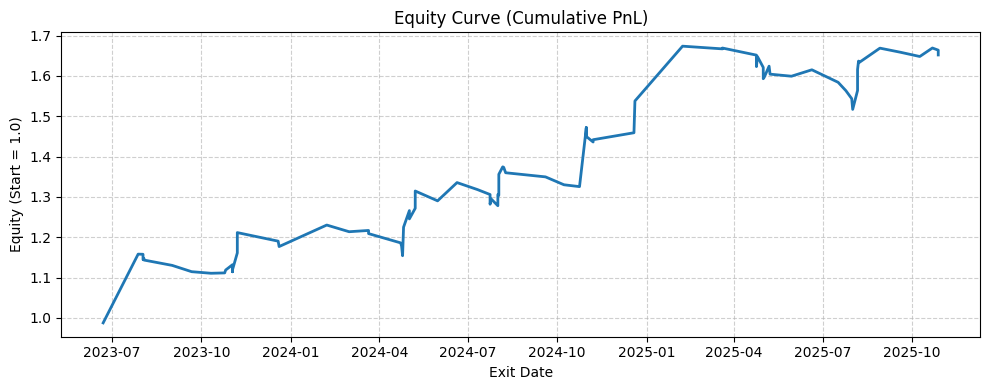

In [248]:
# === Backtest runner with tuning knobs ===
#TICKERS = ["WHR","COP","EOG","ROKU","UBER"]
TICKERS = ["AAPL","GOOG","MSFT","SLB","AA","WHR","COP","EOG","ROKU","UBER","ELF","ACN","DE","INSW","FDX","PEP"]
MAX_FILINGS = 8
TSL_PCT = 0.02
HORIZON_DAYS = 28

# ---- TUNING KNOBS ----
MIN_ABS_PRED_PCT = 3        # e.g., 0.5, 1.0, 2.0
DIRECTION_RULE   = "dsent_sign"  # "dsent_sign" or "pred_sign"
REUSE_CSV        = True         # set False to rebuild event CSV now

trades_df, summary = backtest_trading_strategy(
    TICKERS,
    max_filings_per_ticker=MAX_FILINGS,
    tsl_pct=TSL_PCT,
    horizon_days=HORIZON_DAYS,
    reuse_csv=REUSE_CSV,
    min_abs_pred_pct=MIN_ABS_PRED_PCT,
    direction_rule=DIRECTION_RULE,
)
display(trades_df.head(10))
print(summary)

equity_series = plot_equity_curve(trades_df)